In [16]:
import numpy as np
from scipy.io.idl import readsav
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#mpl.use('macosx')
#sns.set()

# Integrating away the MinXSS data denominators

We'll define some functions to handle integrating across the MinXSS science data, which are in photons / s / cm2 / keV. These first two functions will remove the /keV and /s, respectively. Then we create a function to account for the fact that we took these measurements at 1 AU, which gets rid of the /cm2.

In [18]:
def integrate_spectrum_energy(spectral_irradiance, energy):
    irradiance_masked = np.ma.array(spectral_irradiance, mask=np.isnan(spectral_irradiance))  # Causes the units to get dropped
    return np.trapz(irradiance_masked, energy)


def integrate_spectrum_time(irradiance, time_jd):
    time_seconds = (time_jd - time_jd[0]) * 86400 * u.second
    return np.trapz(irradiance, time_seconds)


def integrate_photon_flux_1au(fluxes):
    return [flux * 4 * np.pi * ((1*u.AU).to(u.cm))**2 for flux in fluxes]

# Other handy functions

Now we define a function that'll just fit a slope over whatever data you pass it, and plot over the most recent plot. We also restrict the xrange that the fit is applied to, and provide some default parameters for that.

In [19]:
def fit_slope(x, y, xmin=2e30, xmax=1e32):
    mask = (x >= xmin) & (x <= xmax)
    logx = np.log10(x[mask])
    logy = np.log10(y[mask])
    p = np.polyfit(logx, logy, deg=1)
    xfit = np.logspace(np.floor(np.log10(xmin)), np.floor(np.log10(xmax)), num=30)
    line = 10**p[1] * xfit ** p[0]
    plt.plot(xfit, line)
    plt.title('$\\alpha$ = {0:.2f}'.format(p[0]))

Finally we have a convenience function for extracting the julian date from the MinXSS data product, since it's kind of an ugly accessor. 

In [20]:
def extract_time_jd(minxsslevel1):
    return np.array([minxsslevel1['time'][i]['jd'][0] for i in range(len(minxsslevel1))])

# Read data

In [13]:
data_path = '/Users/jmason86/Dropbox/minxss_dropbox/data/fm1/level1/'
data = readsav('{}minxss1_l1_mission_length_v2.sav'.format(data_path))
minxsslevel1 = data.minxsslevel1.x123[0].copy()
spectral_irradiance = np.stack(minxsslevel1['irradiance']) * (u.photon / u.second / u.centimeter**2 / u.keV)
energy = minxsslevel1[0]['energy']

goes_events_path = '/Users/jmason86/Dropbox/Research/Data/GOES/events/'
data_goes = readsav('{}GOES_events_MinXSS1_era.sav'.format(goes_events_path))
goes_events = data_goes.goesevents.copy()
goes_start_jd = goes_events['eventstarttimejd']
goes_end_jd = goes_start_jd + 1/24  # Nearly all flares are << 1 hour. The post-flare time intensity is much smaller and will add little to the time-integrated value

# Histograms

## Histogram of dN/dE per year vs energy [erg]

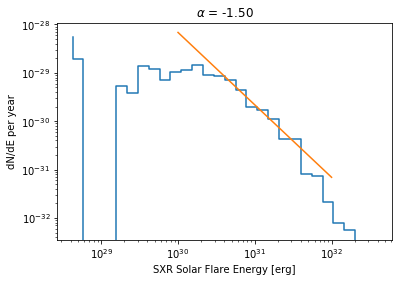

In [21]:
# Integrate spectra across energy to produce one value per time
irradiance = integrate_spectrum_energy(spectral_irradiance, energy) * (u.photon / u.second / u.centimeter**2)

# Integrate across the times of all flares
time_jd = extract_time_jd(minxsslevel1)
# Loop through all the flares identified by GOES
photon_fluxes = []
for i in range(len(goes_start_jd)):
    flare_time_indices = np.where((time_jd >= goes_start_jd[i]) & (time_jd <= goes_end_jd[i]))
    if flare_time_indices[0].size > 1:
        photon_fluxes.append(integrate_spectrum_time(irradiance[flare_time_indices], time_jd[flare_time_indices]))

# Now integrate that over 1 AU to get rid of the / cm^2
photons = integrate_photon_flux_1au(photon_fluxes)

# Convert energy units from keV to erg
energy_erg = u.keV.to(u.erg, energy) * u.erg

# Convert photons to energy
mean_energy = np.ma.array(energy_erg, mask=(energy_erg < 0)).mean() / u.photon
measured_energy = [photon * mean_energy for photon in photons]

# Prepare for histograms
m_e = np.array([m.value for m in measured_energy])
log_bins = np.geomspace(m_e.min(), m_e.max(), 30)
bin_centers = np.sqrt(log_bins[1:] * log_bins[:-1])

# Count number of flares in each bin: N
hist = np.histogram(m_e, bins=log_bins)
n = hist[0]

# Divide N by energy of its corresponding bin
dn_de = n / bin_centers

# Divide all bins by the duration of observations in years
observation_duration_years = (minxsslevel1['time'][-1]['jd'] - minxsslevel1['time'][0]['jd']) / 365.25
dn_de_per_year = dn_de / observation_duration_years

plt.figure()
plt.step(bin_centers, dn_de_per_year)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('SXR Solar Flare Energy [erg]')
plt.ylabel('dN/dE per year')

fit_slope(bin_centers, dn_de_per_year)

## Histogram of flare peak flux 